In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import collections

In [ ]:
# Read data
trainA = pd.read_csv('./data/trainA',sep=' ',header=None, names=['x','y','class'])
trainB = pd.read_csv('./data/trainB',sep=' ',header=None, names=['x','y','class'])
trainC = pd.read_csv('./data/trainC',sep=' ',header=None, names=['x','y','class'])
testA = pd.read_csv('./data/testA',sep=' ',header=None, names=['x','y','class'])
testB = pd.read_csv('./data/testB',sep=' ',header=None, names=['x','y','class'])
testC = pd.read_csv('./data/testC',sep=' ',header=None, names=['x','y','class'])

The files trainA, trainB and trainC contain samples of data (xn,yn) (each line of each file contains the 2 components of xn then yn). The goal here is to implement the following classification methods and to test them on the three data sets:
* Linear Classification
    * Generative model (LDA): Given the class variable, the data are assumed to be Gaussian with different means for different classes but with the same covariance matrix.
    * Logistic regression: Same with Logistic regression with function f(x)=w⊺x+b
    * Linear regression: Considering class y as a real valued variable taking the values 0 and 1 only, linear regression is implemented (for an affine function f(x)=w⊺x+b) by solving the normal equations.

Data in the files testA, testB and testC are respectively drawn from the same distribution as the data in the files trainA, trainB and trainC. The different models are tested from the corresponding training data on these test data with comparison of their misclassifica.
    
* 


## LDA

#### A quick glance at the data

/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


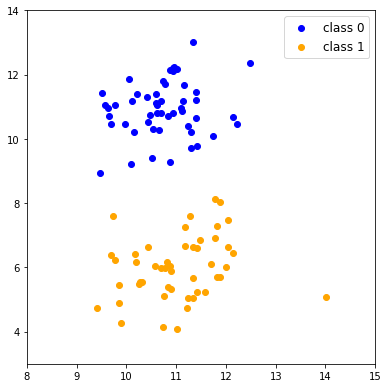

In [6]:
# plot
train = trainA
train_0 = train[train['class']==0]
train_1 = train[train['class']==1]
# Plot bounding boxes (just for nice visualization)
# trainA
xmin = 8
xmax = 15
ymin = 3
ymax = 14
# trainB
#xmin = 6
#xmax = 18
#ymin = 0
#ymax = 16
# trainC
#xmin = 6
#xmax = 17
#ymin = 2
#ymax = 15
fig = plt.figure(figsize=(5.5,5.5))
plt.scatter(train_0['x'],train_0['y'],color='b',label='class 0')
plt.scatter(train_1['x'],train_1['y'],color='orange',label='class 1')
plt.axes().set_xlim(xmin,xmax)
plt.axes().set_ylim(ymin,ymax)
plt.legend(fontsize=12,title_fontsize=14)
plt.tight_layout()
plt.savefig('LDA_trainA_basic.png',dpi=100)

#### Maximum likelihood estimators

**LDA:**       $\ \ \ \ \hat{\pi} = \frac{1}{N}\sum_{n=1}^N{y_n} \ \ \ \ \hat{\mu}_{0/1} = \frac{1}{|X_{0/1}|}\sum_{x\in X_{0/1}}x \ \ \ \ \hat{\Sigma} = \frac{1}{N}\sum_{n=1}^N{(x_n-\hat{\mu}_{y_n})(x_n-\hat{\mu}_{y_n})^\top}$

**QDA:**       $\ \ \ \ \hat{\pi} = \frac{1}{N}\sum_{n=1}^N{y_n} \ \ \ \  \hat{\mu}_{0/1} = \frac{1}{|X_{0/1}|}\sum_{x\in X_{0/1}}x \ \ \ \ \hat{\Sigma}_{0/1} = \frac{1}{|X_{0/1}|}\sum_{x_n \in X_{0/1}}{(x_n-\hat{\mu}_{y_n})(x_n-\hat{\mu}_{y_n})^\top}$

In [36]:
# Maximum likelihood estimators for LDA & QDA
def MLE(train, mode):
    train_0 = train[train['class'] == 0]
    train_1 = train[train['class'] == 1]
    N_0 = train_0.shape[0]
    N_1 = train_1.shape[0]
    N = N_0 + N_1
    pi = N_1/N
    m_0 = np.array([train_0['x'].sum(), train_0['y'].sum()]) / N_0
    m_1 = np.array([train_1['x'].sum(), train_1['y'].sum()]) / N_1
    m = [m_0,m_1]
    sig_0 = np.zeros((2,2))
    sig_1 = np.zeros((2,2))
    sigs = [sig_0, sig_1]
    
    for i in range(N):
        cls = int(train.iloc[i]['class'])
        v = np.array(train.iloc[i][['x','y']] - m[cls])
        v = v.reshape((2,1))
        sigs[cls] += v @ v.T
    
    if mode=='LDA':
        sig = (sig_0 + sig_1)/N
        return pi, m_0, m_1, sig
    elif mode=='QDA':
        sig_0 /= N_0
        sig_1 /= N_1
        return pi, m_0, m_1, sig_0, sig_1

#### Line estimation (LDA)

In [37]:
# Compute the line p(class=1|coordinates) = 0.5
# Input:  x coordinate and line parameters
# Output: corresponding y coordinate on the line
def line(x,pi,m_0,m_1,sig,sig_inv=None):
    if sig_inv is None:
        sig_inv = np.linalg.inv(sig)
    beta = np.matmul(m_0-m_1,sig_inv)
    c = np.log((1-pi)/pi)-0.5*np.dot(m_0+m_1,np.matmul(sig_inv,m_0-m_1))
    return -(c+beta[0]*x)/beta[1]

In [38]:
# prediction
def predict_LDA(data, pi, m_0, m_1, sig):
    sig_inv = np.linalg.inv(sig)
    preds = np.empty(data.shape[0])
    for i in range(data.shape[0]):
        # for the x coordinate get the y line coordinate
        yl = line(data['x'][i],pi,m_0,m_1,sig,sig_inv)
        # point is over the line
        if data['y'][i] > yl:
            preds[i] = 0
        # point is under (or on) the line
        else:
            preds[i] = 1
    return preds

In [39]:
def plot_LDA(data, pi, m_0, m_1, sig, xmin, xmax, ymin, ymax, contour_levels):
    data_0 = data[data['class']==0]
    data_1 = data[data['class']==1]

    # plot
    # create a grid
    X = np.linspace(xmin, xmax, 50)
    Y = np.linspace(ymin, ymax, 50)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    # create gaussians
    gaussian_0 = multivariate_normal(m_0,sig)
    gaussian_1 = multivariate_normal(m_1,sig)
    Z_0 = gaussian_0.pdf(pos)
    Z_1 = gaussian_1.pdf(pos)
    Z = (1-pi)*Z_0 + pi*Z_1

    # plot points and distribution
    fig = plt.figure(figsize=(5.5,5.5))
    ax = plt.axes()
    ax.contour(X,Y,Z,levels=contour_levels,colors='k')
    ax.contourf(X,Y,Z,levels=50,cmap="gray_r")
    ax.scatter(data_0['x'],data_0['y'],color='b',label='class 0')
    ax.scatter(data_1['x'],data_1['y'],color='orange',label='class 1')
    # separation line
    ax.plot([xmin,xmax],[line(xmin,pi,m_0,m_1,sig),line(xmax,pi,m_0,m_1,sig)],color='r')
    #plt.text(13,8.7,'p(class=1)=0.5',size=12,rotation=10)
    ax.legend(fontsize=12,title_fontsize=14)
    fig.tight_layout()
    return fig,ax

#### dataset A

Parameters:
m_0: [10.73248858 10.93983367]
m_1: [11.03264581  5.99294053]
sig:
[[0.58821974 0.13912842]
 [0.13912842 0.81959919]]
Train misclassified: 0/100
Test misclassified: 1/100


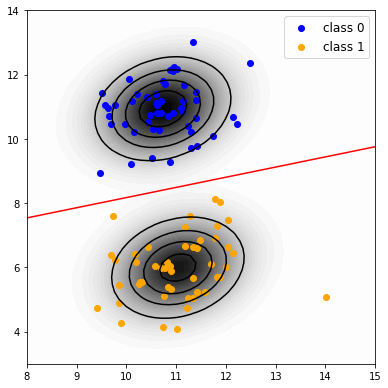

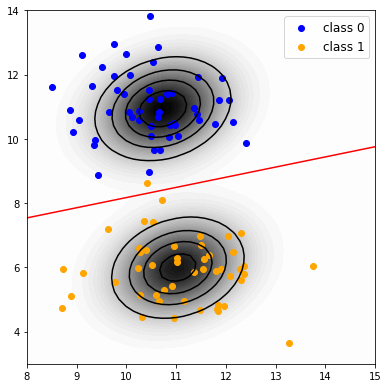

In [40]:
# parameters
xmin = 8
xmax = 15
ymin = 3
ymax = 14
contour_levels = 4
data = trainA

# training
pi, m_0, m_1, sig = MLE(data, mode='LDA')
print('Parameters:')
print('m_0:',m_0)
print('m_1:',m_1)
print('sig:')
print(sig)
fig, ax = plot_LDA(data, pi, m_0, m_1, sig, xmin, xmax, ymin, ymax, contour_levels)
preds = predict_LDA(data,pi,m_0,m_1,sig)
misclassified = np.logical_xor(preds,data['class']).sum()
print('Train misclassified: %d/%d'%(misclassified,data.shape[0]))
#fig.savefig('LDA_trainA.png',dpi=100)

# prediction
data = testA
preds = predict_LDA(data,pi,m_0,m_1,sig)
misclassified = np.logical_xor(preds,data['class']).sum()
print('Test misclassified: %d/%d'%(misclassified,data.shape[0]))
fig, ax = plot_LDA(data, pi, m_0, m_1, sig, xmin, xmax, ymin, ymax, contour_levels)
#fig.savefig('LDA_testA.png',dpi=100)

#### dataset B

Parameters:
m_0: [10.58256756 11.17169818]
m_1: [11.24757662  6.095283  ]
sig:
[[1.64391088 0.70139847]
 [0.70139847 2.0605845 ]]
Train misclassified: 4/200
Test misclassified: 9/200


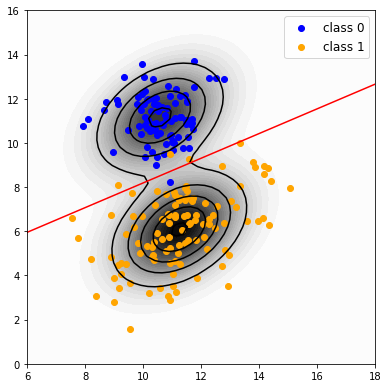

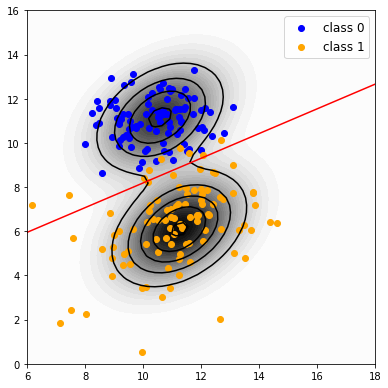

In [41]:
# parameters
xmin = 6
xmax = 18
ymin = 0
ymax = 16
contour_levels = 5
data = trainB

# MLE
pi, m_0, m_1, sig = MLE(data, mode='LDA')
print('Parameters:')
print('m_0:',m_0)
print('m_1:',m_1)
print('sig:')
print(sig)
fig, ax = plot_LDA(data, pi, m_0, m_1, sig, xmin, xmax, ymin, ymax, contour_levels)
preds = predict_LDA(data,pi,m_0,m_1,sig)
misclassified = np.logical_xor(preds,data['class']).sum()
print('Train misclassified: %d/%d'%(misclassified,data.shape[0]))
#fig.savefig('LDA_trainB.png',dpi=100)

# prediction
data = testB
preds = predict_LDA(data,pi,m_0,m_1,sig)
misclassified = np.logical_xor(preds,data['class']).sum()
print('Test misclassified: %d/%d'%(misclassified,data.shape[0]))
fig, ax = plot_LDA(data, pi, m_0, m_1, sig, xmin, xmax, ymin, ymax, contour_levels)
#fig.savefig('LDA_testB.png',dpi=100)

#### dataset C

Parameters:
m_0: [10.6192273  10.83868653]
m_1: [11.18463199  6.04249315]
sig:
[[ 1.27823018 -0.06243809]
 [-0.06243809  1.66584186]]
Train misclassified: 8/300
Test misclassified: 12/300


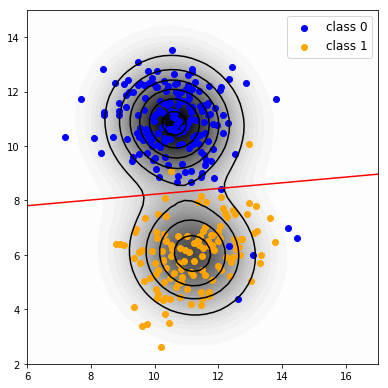

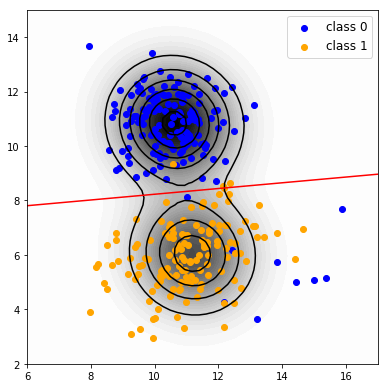

In [42]:
# parameters
xmin = 6
xmax = 17
ymin = 2
ymax = 15
contour_levels = 6
data = trainC

# Train
pi, m_0, m_1, sig = MLE(data, mode='LDA')
print('Parameters:')
print('m_0:',m_0)
print('m_1:',m_1)
print('sig:')
print(sig)
fig, ax = plot_LDA(data, pi, m_0, m_1, sig, xmin, xmax, ymin, ymax, contour_levels)
preds = predict_LDA(data,pi,m_0,m_1,sig)
misclassified = np.logical_xor(preds,data['class']).sum()
print('Train misclassified: %d/%d'%(misclassified,data.shape[0]))
#fig.savefig('LDA_trainC.png',dpi=100)

# Test
data = testC
preds = predict_LDA(data,pi,m_0,m_1,sig)
misclassified = np.logical_xor(preds,data['class']).sum()
print('Test misclassified: %d/%d'%(misclassified,data.shape[0]))
fig, ax = plot_LDA(data, pi, m_0, m_1, sig, xmin, xmax, ymin, ymax, contour_levels)
#fig.savefig('LDA_testC.png',dpi=100)

## Logistic Regression

Find the best fit for an affine function $y=w^\top x+b$ using logistic regression.

In [43]:
def LogReg(train):
    # Prepare the data
    N = train.shape[0]
    X_lin = np.array([train.iloc[i][['x', 'y']] for i in range(N)])
    X_aff = np.hstack((X_lin, np.ones((N, 1))))
    y = np.array([train.iloc[i][['class']] for i in range(N)])
    # run Newton interior point method
    w_init = np.zeros((3, 1))
    w = (w_init - np.linalg.inv(hess(X_aff, w_init)) 
         @ grad(X_aff, y, w_init))
    return np.split(w.squeeze(), [2])

    # w_aff = np.linalg.pinv(X_aff) @ y
    # return np.split(w_aff.squeeze(), [2])

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def eta(X, w):
    eta = sigmoid(X @ w)
    assert eta.shape == (X.shape[0], 1)
    return eta

def grad(X, y, w):
    grad = X.T @ (y - eta(X, w))
    assert grad.shape == (3, 1)
    return grad

def hess(X, w):
    hess = -X.T @ np.diag((eta(X, w) * (1 - eta(X, w))).squeeze()) @ X
    assert hess.shape == (3, 3)
    return hess

In [44]:
# Compute the line p(class=1|coordinates) = p
# Input:  x coordinate and line parameters
# Output: corresponding y coordinate on the line
def line_LogReg(x, w, b):
    return - (w[0]*x + b) / w[1]

In [45]:
# prediction
def predict_LogReg(data, w, b):
    preds = np.empty(data.shape[0])
    for i in range(data.shape[0]):
        x = np.array(data.iloc[i][['x', 'y']])
        p = w @ x + b
        if p >= 0:
            preds[i] = 1
        else:
            preds[i] = 0
    return preds

In [46]:
def plot_LogReg(data, w, b, xmin, xmax, ymin, ymax):
    data_0 = data[data['class']==0]
    data_1 = data[data['class']==1]

    # plot
    # create a grid
    X = np.linspace(xmin, xmax, 50)
    Y = np.linspace(ymin, ymax, 50)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    # calculate predicted probability over the grid
    Z = np.array([[sigmoid(w @ pos[i,j] + b) for j in range(pos.shape[1])] 
                  for i in range(pos.shape[0])])
    Z[Z > 1] = 1; Z[Z < 0] = 0; Z = Z.squeeze();
    
    # plot points and distribution
    fig = plt.figure(figsize=(5.5,5.5))
    ax = plt.axes()
    ax.contourf(X,Y,Z,levels=50,cmap="gray_r")
    ax.scatter(data_0['x'],data_0['y'],color='b',label='class 0')
    ax.scatter(data_1['x'],data_1['y'],color='orange',label='class 1')
    # separation line
    ax.plot([xmin,xmax],[line_LogReg(xmin,w,b),line_LogReg(xmax,w,b)],color='r')
    ax.legend(fontsize=12,title_fontsize=14)
    fig.tight_layout()
    return fig,ax

In [77]:
def treat_data_LogReg(train, test, xmin, xmax, ymin, ymax):
    # Train
    data = train
    w, b = LogReg(data)
    print('Parameters:')
    print('w:',w)
    print('b:',b)

    fig, ax = plot_LogReg(data, w, b, xmin, xmax, ymin, ymax)
    preds = predict_LogReg(data, w, b)
    misclassified = np.logical_xor(preds,data['class']).sum()
    print('Train misclassified: %d/%d'%(misclassified, data.shape[0]))
    #fig.savefig('LogReg_trainC.png',dpi=100)
    
    # Test
    data = test
    preds = predict_LogReg(data, w, b)
    misclassified = np.logical_xor(preds,data['class']).sum()
    print('Test misclassified: %d/%d'%(misclassified, data.shape[0]))
    fig, ax = plot_LogReg(data, w, b, xmin, xmax, ymin, ymax)
    #fig.savefig('LogReg_testA.png',dpi=100)

#### dataset A

Parameters:
w: [ 0.22329753 -0.70546545]
b: [3.53383096]
Train misclassified: 0/100
Test misclassified: 1/100


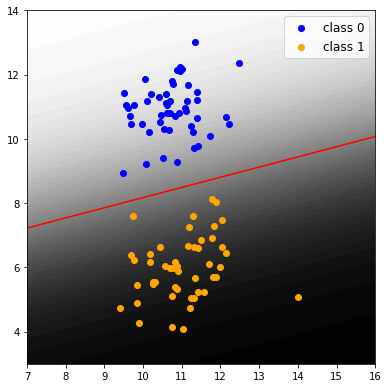

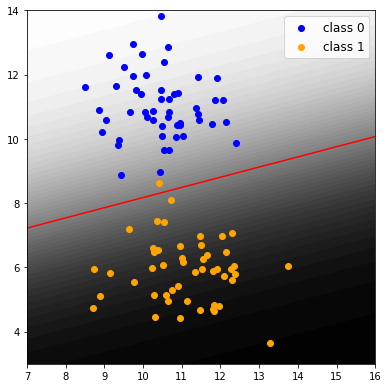

In [74]:
# parameters
xmin = 7
xmax = 16
ymin = 3
ymax = 14

treat_data_LogReg(trainA, testA, xmin, xmax, ymin, ymax)

#### dataset B

Parameters:
w: [ 0.3303269  -0.59030068]
b: [1.52999937]
Train misclassified: 4/200
Test misclassified: 9/200


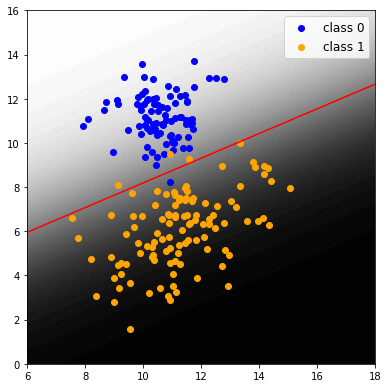

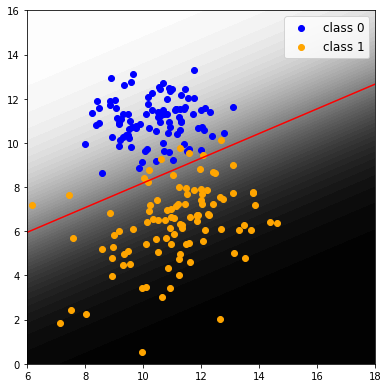

In [76]:
# parameters
xmin = 6
xmax = 18
ymin = 0
ymax = 16

treat_data_LogReg(trainB, testB, xmin, xmax, ymin, ymax)

#### dataset C

Parameters:
w: [ 0.06701844 -0.63588697]
b: [4.56060824]
Train misclassified: 8/300
Test misclassified: 12/300


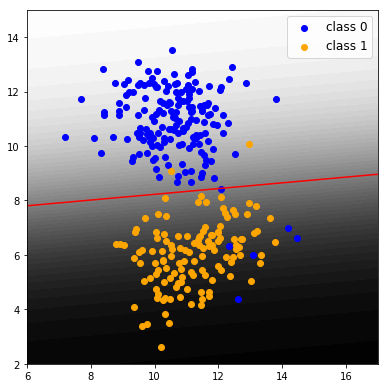

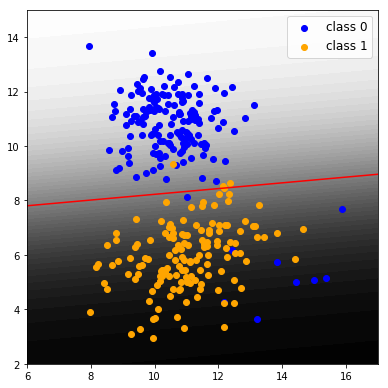

In [79]:
# parameters
xmin = 6
xmax = 17
ymin = 2
ymax = 15

treat_data_LogReg(trainC, testC, xmin, xmax, ymin, ymax)

## Linear Regression

Find the best fit for an affine function $y=w^\top x+b$ using linear regression.

In [51]:
# train the linear regression, returning w and b 
def LinReg(train):
    N = train.shape[0]
    X_lin = np.array([train.iloc[i][['x', 'y']] for i in range(N)])
    X_aff = np.hstack((X_lin, np.ones((N, 1))))
    y = np.array([train.iloc[i][['class']] for i in range(N)])
    w_aff = np.linalg.pinv(X_aff) @ y
    return np.split(w_aff.squeeze(), [2])

In [52]:
# Compute the line p(class=1|coordinates) = p
# Input:  x coordinate and line parameters
# Output: corresponding y coordinate on the line
def line_LinReg(x, p, w, b):
    return (p - w[0]*x - b) / w[1]

In [53]:
# prediction
def predict_LinReg(data, w, b):
    preds = np.empty(data.shape[0])
    for i in range(data.shape[0]):
        x = np.array(data.iloc[i][['x', 'y']])
        p = w @ x + b
        if p >= 0.5:
            preds[i] = 1
        else:
            preds[i] = 0
    return preds

In [54]:
def plot_LinReg(data, w, b, xmin, xmax, ymin, ymax):
    data_0 = data[data['class']==0]
    data_1 = data[data['class']==1]

    # plot
    # create a grid
    X = np.linspace(xmin, xmax, 50)
    Y = np.linspace(ymin, ymax, 50)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    # calculate predicted probability over the grid
    Z = np.array([[w @ pos[i,j] + b for j in range(pos.shape[1])] 
                  for i in range(pos.shape[0])])
    Z[Z > 1] = 1; Z[Z < 0] = 0; Z = Z.squeeze();
    
    # plot points and distribution
    fig = plt.figure(figsize=(5.5,5.5))
    ax = plt.axes()
    ax.contourf(X,Y,Z,levels=50,cmap="gray_r")
    ax.scatter(data_0['x'],data_0['y'],color='b',label='class 0')
    ax.scatter(data_1['x'],data_1['y'],color='orange',label='class 1')
    # separation line
    ax.plot([xmin,xmax],[line_LinReg(xmin,0.5,w,b),line_LinReg(xmax,0.5,w,b)],color='r')
    ax.legend(fontsize=12,title_fontsize=14)
    fig.tight_layout()
    return fig,ax

In [87]:
def treat_data_LinReg(train, test, xmin, xmax, ymin, ymax):
    # Train
    data = train
    w, b = LinReg(data)
    print('Parameters:')
    print('w:',w)
    print('b:',b)

    fig, ax = plot_LinReg(data, w, b, xmin, xmax, ymin, ymax)
    preds = predict_LinReg(data, w, b)
    misclassified = np.logical_xor(preds,data['class']).sum()
    print('Train misclassified: %d/%d'%(misclassified, data.shape[0]))
    #fig.savefig('LinReg_trainB.png',dpi=100)

    # Test
    data = test
    preds = predict_LinReg(data, w, b)
    misclassified = np.logical_xor(preds,data['class']).sum()
    print('Test misclassified: %d/%d'%(misclassified, data.shape[0]))
    fig, ax = plot_LinReg(data, w, b, xmin, xmax, ymin, ymax)
    #fig.savefig('LinReg_testB.png',dpi=100)

#### dataset A

Parameters:
w: [ 0.05582438 -0.17636636]
b: [1.38345774]
Train misclassified: 0/100
Test misclassified: 1/100


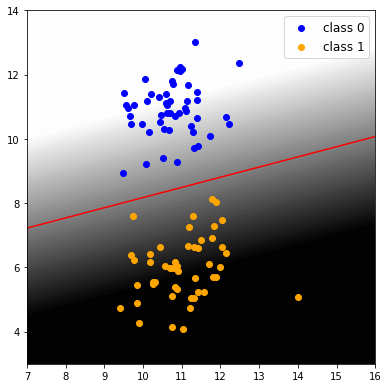

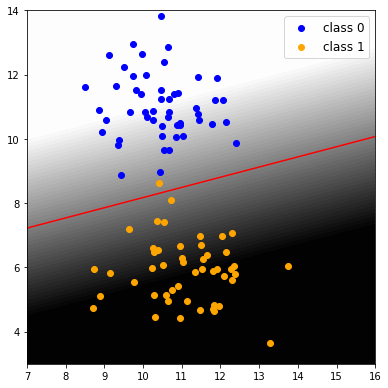

In [82]:
# parameters
xmin = 7
xmax = 16
ymin = 3
ymax = 14

treat_data_LinReg(trainA, testA, xmin, xmax, ymin, ymax)

#### dataset B

Parameters:
w: [ 0.08258172 -0.14757517]
b: [0.88249984]
Train misclassified: 4/200
Test misclassified: 9/200


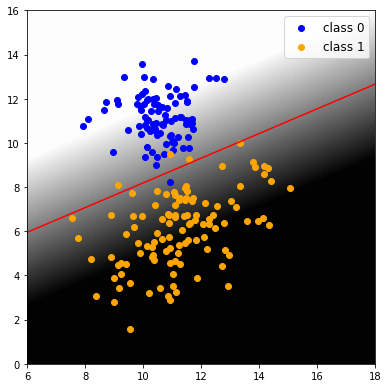

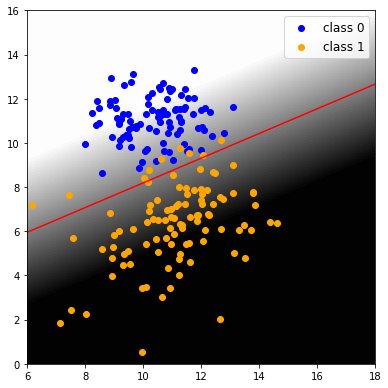

In [88]:
# parameters
xmin = 6
xmax = 18
ymin = 0
ymax = 16

treat_data_LinReg(trainB, testB, xmin, xmax, ymin, ymax)

#### dataset C

Parameters:
w: [ 0.01675461 -0.15897174]
b: [1.64015206]
Train misclassified: 8/300
Test misclassified: 12/300


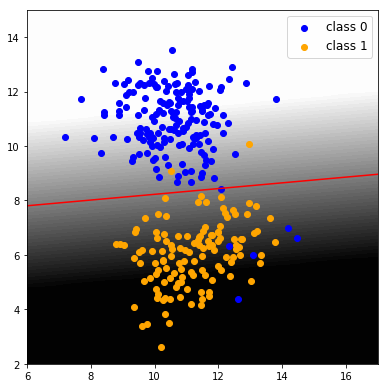

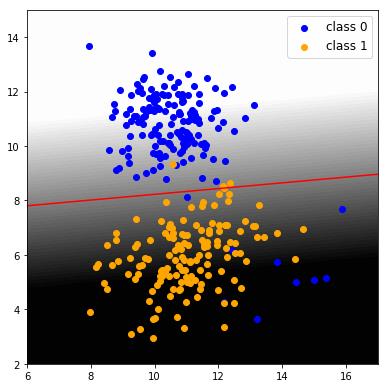

In [86]:
# parameters
xmin = 6
xmax = 17
ymin = 2
ymax = 15

treat_data_LinReg(trainC, testC, xmin, xmax, ymin, ymax)

## QDA

#### cone estimation

To compute the cone we will use the following formula (derivation see report)

$(x-\mu_0)^\top \Sigma_0^{-1}(x-\mu_0)-(x-\mu_1)^\top \Sigma_1^{-1}(x-\mu_1) = -2\ln(\frac{\pi}{1-\pi}\sqrt{\frac{|\Sigma_0|}{|\Sigma_1|}})$

In [59]:
# computes the cone value at a (x,y) coordinate (parameter x shall be an np.array of the two coordinates)
def cone_value(m_0, m_1, sig_0_inv, sig_1_inv, x):
    xm0 = x-m_0
    xm1 = x-m_1
    l = np.dot(xm0,np.matmul(sig_0_inv,xm0))
    r = np.dot(xm1,np.matmul(sig_1_inv,xm1))
    return l-r

In [60]:
def plot_QDA(data, pi, m_0, m_1, sig_0, sig_1, xmin, xmax, ymin, ymax, contour_levels):
    data_0 = data[data['class']==0]
    data_1 = data[data['class']==1]

    # Plotting
    # create a grid
    X = np.linspace(xmin, xmax, 50)
    Y = np.linspace(ymin, ymax, 50)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    # create gaussians
    gaussian_0 = multivariate_normal(m_0,sig_0)
    gaussian_1 = multivariate_normal(m_1,sig_1)
    Z_0 = gaussian_0.pdf(pos)
    Z_1 = gaussian_1.pdf(pos)
    Z = pi*Z_1 + (1-pi)*Z_0

    # calculate cone value
    sig_0_inv = np.linalg.inv(sig_0)
    sig_1_inv = np.linalg.inv(sig_1)
    cone_threshold = -2*np.log(pi/(1-pi) * np.sqrt(np.linalg.det(sig_0)/np.linalg.det(sig_1)))
    cone_vals = np.empty(Z.shape)
    for idx_y in range(Z.shape[0]):
        for idx_x in range(Z.shape[1]):
            x = pos[idx_y,idx_x,0]
            y = pos[idx_y,idx_x,1]
            cone_vals[idx_y,idx_x] = cone_value(m_0, m_1, sig_0_inv, sig_1_inv, np.array([x,y]))
            
    # plot points and distribution
    fig = plt.figure(figsize=(5.5,5.5))
    ax = plt.axes()
    ax.contour(X,Y,Z,levels=contour_levels,colors='k')
    ax.contourf(X,Y,Z,levels=50,cmap="gray_r")
    ax.scatter(data_0['x'],data_0['y'],color='b',label='class 0')
    ax.scatter(data_1['x'],data_1['y'],color='orange',label='class 1')
    # separation cone
    ax.contour(X,Y,cone_vals,levels=[cone_threshold],colors='r',linestyles='solid')
    #plt.text(13,8.7,'p(class=1)=0.5',size=12,rotation=10)
    ax.legend(fontsize=12,title_fontsize=14)
    fig.tight_layout()
    return fig,ax

In [61]:
def predict_QDA(data, pi, m_0, m_1, sig_0, sig_1):
    sig_0_inv = np.linalg.inv(sig_0)
    sig_1_inv = np.linalg.inv(sig_1)
    preds = np.empty(data.shape[0])
    boundary = -2*np.log(pi/(1-pi) * np.sqrt(np.linalg.det(sig_0)/np.linalg.det(sig_1)))
    for i in range(data.shape[0]):
        cv = cone_value(m_0, m_1, sig_0_inv, sig_1_inv, np.array([data['x'][i],data['y'][i]]))
        # probability y=1 < 0.5
        if cv < boundary:
            preds[i] = 0
        # probability y=1 >= 0.5
        else:
            preds[i] = 1
    return preds

#### dataset A

Parameters:
m_0: [10.73248858 10.93983367]
m_1: [11.03264581  5.99294053]
sig_0:
[[0.46464757 0.0989291 ]
 [0.0989291  0.71324415]]
sig_1:
[[0.7220896  0.18267769]
 [0.18267769 0.93481714]]
Train misclassified: 0/100
Test misclassified: 1/100


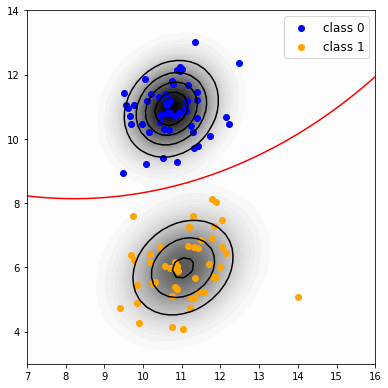

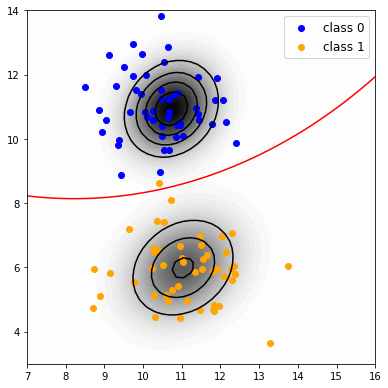

In [62]:
# parameters
xmin = 7
xmax = 16
ymin = 3
ymax = 14
contour_levels = 4
data = trainA

# Train
pi, m_0, m_1, sig_0, sig_1 = MLE(data, mode='QDA')
print('Parameters:')
print('m_0:',m_0)
print('m_1:',m_1)
print('sig_0:')
print(sig_0)
print('sig_1:')
print(sig_1)

fig, ax = plot_QDA(data, pi, m_0, m_1, sig_0, sig_1, xmin, xmax, ymin, ymax, contour_levels)
preds = predict_QDA(data, pi, m_0, m_1, sig_0, sig_1)
misclassified = np.logical_xor(preds,data['class']).sum()
print('Train misclassified: %d/%d'%(misclassified,data.shape[0]))
#fig.savefig('QDA_trainA.png',dpi=100)


# Test
data = testA
preds = predict_QDA(data,pi,m_0,m_1,sig_0, sig_1)
misclassified = np.logical_xor(preds,data['class']).sum()
print('Test misclassified: %d/%d'%(misclassified,data.shape[0]))
fig, ax = plot_QDA(data, pi, m_0, m_1, sig_0, sig_1, xmin, xmax, ymin, ymax, contour_levels)
#fig.savefig('QDA_testA.png',dpi=100)

#### dataset B

Parameters:
m_0: [10.58256756 11.17169818]
m_1: [11.24757662  6.095283  ]
sig_0:
[[0.76164392 0.05352417]
 [0.05352417 1.10741986]]
sig_1:
[[2.36576566 1.23147744]
 [1.23147744 2.84044647]]
Train misclassified: 3/200
Test misclassified: 5/200


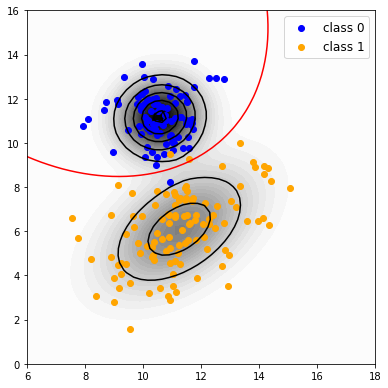

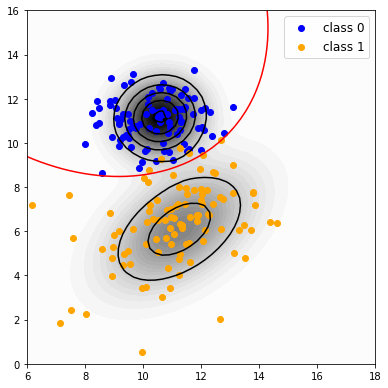

In [63]:
# parameters
xmin = 6
xmax = 18
ymin = 0
ymax = 16
contour_levels = 5
data = trainB

# MLE
pi, m_0, m_1, sig_0, sig_1 = MLE(data, mode='QDA')
print('Parameters:')
print('m_0:',m_0)
print('m_1:',m_1)
print('sig_0:')
print(sig_0)
print('sig_1:')
print(sig_1)
fig, ax = plot_QDA(data, pi, m_0, m_1, sig_0, sig_1, xmin, xmax, ymin, ymax, contour_levels)
preds = predict_QDA(data, pi, m_0, m_1, sig_0, sig_1)
misclassified = np.logical_xor(preds,data['class']).sum()
print('Train misclassified: %d/%d'%(misclassified,data.shape[0]))
#fig.savefig('QDA_trainB.png',dpi=100)

# Test
data = testB
preds = predict_QDA(data,pi,m_0,m_1,sig_0, sig_1)
misclassified = np.logical_xor(preds,data['class']).sum()
print('Test misclassified: %d/%d'%(misclassified,data.shape[0]))
fig, ax = plot_QDA(data, pi, m_0, m_1, sig_0, sig_1, xmin, xmax, ymin, ymax, contour_levels)
#fig.savefig('QDA_testB.png',dpi=100)

#### dataset C

Parameters:
m_0: [10.6192273  10.83868653]
m_1: [11.18463199  6.04249315]
sig_0:
[[ 1.28576019 -0.43356756]
 [-0.43356756  1.82602425]]
sig_1:
[[1.26768817 0.45714317]
 [0.45714317 1.44158652]]
Train misclassified: 8/300
Test misclassified: 13/300


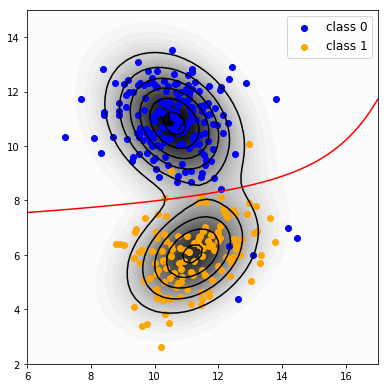

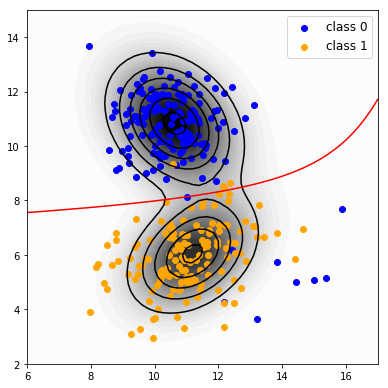

In [64]:
# parameters
xmin = 6
xmax = 17
ymin = 2
ymax = 15
contour_levels = 6
data = trainC

# MLE
pi, m_0, m_1, sig_0, sig_1 = MLE(data, mode='QDA')
print('Parameters:')
print('m_0:',m_0)
print('m_1:',m_1)
print('sig_0:')
print(sig_0)
print('sig_1:')
print(sig_1)
fig, ax = plot_QDA(data, pi, m_0, m_1, sig_0, sig_1, xmin, xmax, ymin, ymax, contour_levels)
preds = predict_QDA(data, pi, m_0, m_1, sig_0, sig_1)
misclassified = np.logical_xor(preds,data['class']).sum()
print('Train misclassified: %d/%d'%(misclassified,data.shape[0]))
#fig.savefig('QDA_trainC.png',dpi=100)

# Test
data = testC
preds = predict_QDA(data,pi,m_0,m_1,sig_0, sig_1)
misclassified = np.logical_xor(preds,data['class']).sum()
print('Test misclassified: %d/%d'%(misclassified,data.shape[0]))
fig, ax = plot_QDA(data, pi, m_0, m_1, sig_0, sig_1, xmin, xmax, ymin, ymax, contour_levels)
#fig.savefig('QDA_testC.png',dpi=100)